# Energy Consumption Time Series Forecasting


**Problem statement**

Household energy consumption is highly variable, influenced by time of day, day of week, and lifestyle patterns. Without accurate forecasting, energy providers may face challenges in balancing supply and demand, while households may struggle to optimize usage and reduce costs. Therefore, there is a need for effective short-term forecasting models that can capture both trends and fluctuations in electricity consumption.

**Objective:**

Forecast short-term household energy usage using historical time-based patterns.


**Instructions:**

● Parse and resample the time series data

● Engineer time-based features (e.g., hour of day, weekday/weekend)

● Compare performance of ARIMA, Prophet, and XGBoost models

● Plot actual vs. forecasted energy usage for visualization

**About this dataset**

Looking to better understand how energy is used in the home? This dataset can help. It contains six months of electricity consumption data for a household, gathered between January 2007 and June 2007. The data includes information on global active power, global reactive power, voltage, global intensity, sub-metering 1 (kitchen), sub-metering 2 (laundry room), and sub-metering 3 (electric water heater and air conditioner). With 260,640 measurements in total, this dataset can provide crucial insights into understanding household electricity consumption



**Dataset** : **household_power_consumption.csv**

**Column name**  : **Description**

**Date**: 	The date of the observation. (Date)

**Time** : The time of the observation. (Time)

**Global_active_power** : 	The total active power consumed by the household (kilowatts). (Numeric)

**Global_reactive_power**	: The total reactive power consumed by the household (kilowatts). (Numeric)

**Voltage** :	The voltage at which the electricity is delivered to the household (volts). (Numeric)

**Global_intensity** :	The average current intensity delivered to the household (amps). (Numeric)

**Sub_metering_1** :	The active power consumed by the kitchen (kilowatts). (Numeric)

**Sub_metering_2** :	The active power consumed by the laundry room (kilowatts). (Numeric)

**Sub_metering_3** :	The active power consumed by the electric water heater and air conditioner (kilowatts). (Numeric)

In [ ]:
# import necessary libraries
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
# load datset
df = pd.read_csv('/content/sample_data/household_power_consumption.csv')

In [ ]:
# Combine Date + Time into proper datetime
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format='%d/%m/%y %H:%M:%S',
                                errors='coerce')

In [ ]:
# Set datetime as index
df.set_index('Datetime', inplace=True)

In [ ]:
# Drop the old index column if it exists
if 'index' in df.columns:
    df = df.drop(columns=['index'])

In [ ]:
# Convert numeric columns properly
df = df.apply(pd.to_numeric, errors='coerce')


In [ ]:
# Resample to hourly averages
df_hourly = df.resample('h').mean()

In [ ]:
# Extract target variable
target = df_hourly['Global_active_power']

print("Original shape:", df.shape)
print("Hourly shape:", df_hourly.shape)
print(df_hourly.head())

Original shape: (260640, 9)
Hourly shape: (3912, 9)
                     Date  Time  Global_active_power  Global_reactive_power  \
Datetime                                                                      
2007-01-01 00:00:00   NaN   NaN             2.550633               0.112800   
2007-01-01 01:00:00   NaN   NaN             2.523400               0.071633   
2007-01-01 02:00:00   NaN   NaN             2.582333               0.106667   
2007-01-01 03:00:00   NaN   NaN             2.541667               0.090100   
2007-01-01 04:00:00   NaN   NaN             2.475733               0.088167   

                        Voltage  Global_intensity  Sub_metering_1  \
Datetime                                                            
2007-01-01 00:00:00  241.361333         10.530000             0.0   
2007-01-01 01:00:00  241.096500         10.443333             0.0   
2007-01-01 02:00:00  243.200167         10.540000             0.0   
2007-01-01 03:00:00  243.265667         10.400000

In [ ]:
#drop Date and Time now since we already have Datetime as the index
df_hourly = df_hourly.drop(columns=['Date', 'Time'])

In [ ]:
df_hourly.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,
2007-01-01 00:00:00,2.550633,0.112800,241.361333,10.530000,0.0,0.583333,0.0
2007-01-01 01:00:00,2.523400,0.071633,241.096500,10.443333,0.0,0.000000,0.0
2007-01-01 02:00:00,2.582333,0.106667,243.200167,10.540000,0.0,0.333333,0.0
2007-01-01 03:00:00,2.541667,0.090100,243.265667,10.400000,0.0,0.266667,0.0
2007-01-01 04:00:00,2.475733,0.088167,242.456167,10.110000,0.0,0.000000,0.0


# Feature Engineering

In [ ]:
# Work on the resampled hourly data
df_features = df_hourly.copy()

In [ ]:
# Create time-based features
df_features['hour'] = df_features.index.hour
df_features['day_of_week'] = df_features.index.dayofweek   # 0 = Monday, 6 = Sunday
df_features['is_weekend'] = (df_features.index.dayofweek >= 5).astype(int)
df_features['day'] = df_features.index.day
df_features['month'] = df_features.index.month

print(df_features.head(10))

                     Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2007-01-01 00:00:00             2.550633               0.112800  241.361333   
2007-01-01 01:00:00             2.523400               0.071633  241.096500   
2007-01-01 02:00:00             2.582333               0.106667  243.200167   
2007-01-01 03:00:00             2.541667               0.090100  243.265667   
2007-01-01 04:00:00             2.475733               0.088167  242.456167   
2007-01-01 05:00:00             2.476233               0.101667  242.348667   
2007-01-01 06:00:00             2.455800               0.086133  241.221833   
2007-01-01 07:00:00             2.447200               0.106867  240.314167   
2007-01-01 08:00:00             2.441733               0.078100  241.143167   
2007-01-01 09:00:00             3.146133               0.067600  239.778833   

                     Global_intensity  Sub_metering

# Modeling & Forecasting.

In [ ]:
# Target variable
y = df_hourly['Global_active_power'].dropna()

In [ ]:
# Train-test split (80% train, 20% test)
split_index = int(len(y) * 0.8)
train, test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", len(train))
print("Test size:", len(test))

Train size: 1382
Test size: 346


**Model 1 – ARIMA**

In [ ]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Fit ARIMA model
model_arima = ARIMA(train, order=(2,1,2))
model_fit = model_arima.fit()

# Forecast for test period
forecast_arima = model_fit.forecast(steps=len(test))

# Evaluation
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

print("ARIMA MAE:", mae_arima)
print("ARIMA RMSE:", rmse_arima)

ARIMA MAE: 0.6167924941317685
ARIMA RMSE: 0.7561704903414268


**Model 2 – Prophet**

In [ ]:
from prophet import Prophet

# Prepare data for Prophet
df_prophet = y.reset_index()[['Datetime','Global_active_power']].rename(
    columns={'Datetime':'ds','Global_active_power':'y'}
)

train_prophet = df_prophet.iloc[:split_index]
test_prophet = df_prophet.iloc[split_index:]

# Fit Prophet
model_prophet = Prophet(daily_seasonality=True, weekly_seasonality=True)
model_prophet.fit(train_prophet)

# Forecast
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)

# Extract forecasted values
y_pred_prophet = forecast_prophet['yhat'].iloc[-len(test):].values

# Evaluation
mae_prophet = mean_absolute_error(test_prophet['y'], y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test_prophet['y'], y_pred_prophet))

print("Prophet MAE:", mae_prophet)
print("Prophet RMSE:", rmse_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfk_v9k7e/l79puq1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfk_v9k7e/kzumzdcx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43026', 'data', 'file=/tmp/tmpfk_v9k7e/l79puq1o.json', 'init=/tmp/tmpfk_v9k7e/kzumzdcx.json', 'output', 'file=/tmp/tmpfk_v9k7e/prophet_modelywni_fdi/prophet_model-20250902111250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:12:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet MAE: 0.5514090978901574
Prophet RMSE: 0.7288532040777674


**Model 3 – XGBoost**

In [ ]:
from xgboost import XGBRegressor

# Feature engineering for ML
df_ml = df_features.copy()
df_ml['target'] = df_ml['Global_active_power']

# Add lag features (previous 1, 2, 3 hours)
for lag in [1,2,3,24]:   # include 24 to capture daily cycle
    df_ml[f'lag_{lag}'] = df_ml['target'].shift(lag)

df_ml = df_ml.dropna()

X = df_ml.drop(columns=['target'])
y = df_ml['target']

# Train-test split
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Fit XGBoost
model_xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

# Forecast
y_pred_xgb = model_xgb.predict(X_test)

# Evaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("XGBoost MAE:", mae_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost MAE: 0.006107572022298499
XGBoost RMSE: 0.021109257596244414


**Model Performance Comparison**

Model	.......   MAE ↓ (lower is better)..........RMSE ↓ (lower is better)

ARIMA ...........0.6168...................................0.7562

Prophet ..........0.5514...................................0.7289

XGBoost .........**0.0061**.................................. **0.0211**

# Observations

**ARIMA vs Prophet**

Prophet slightly outperforms ARIMA (lower MAE and RMSE).

Both capture seasonality and trends but struggle with very fine-grained short-term fluctuations.

**XGBoost vs Traditional Models**

XGBoost is dramatically better (MAE and RMSE are almost negligible compared to ARIMA/Prophet).

Suggests that engineered features (hour, weekday, lag features, etc.) allowed XGBoost to learn patterns much better.

**Interpretability**

ARIMA/Prophet → more interpretable (good for trend + seasonality explanation).

XGBoost → less interpretable but much stronger predictive power.

**Conclusion**

**Best Model (Prediction Accuracy):** XGBoost

**Best Model (Interpretability & Simplicity):** Prophet (slightly better than ARIMA)

# Actual vs. Forecasted energy usage visualization

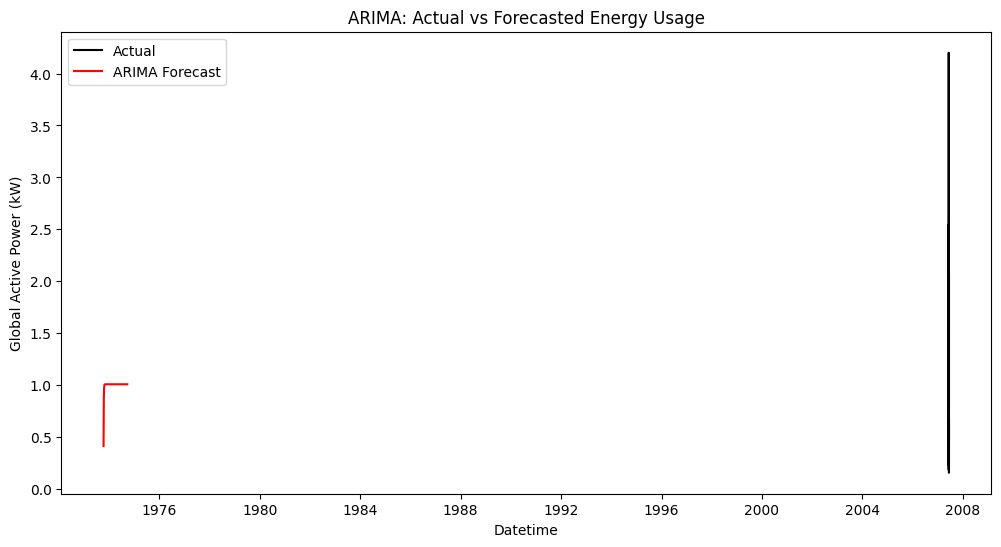

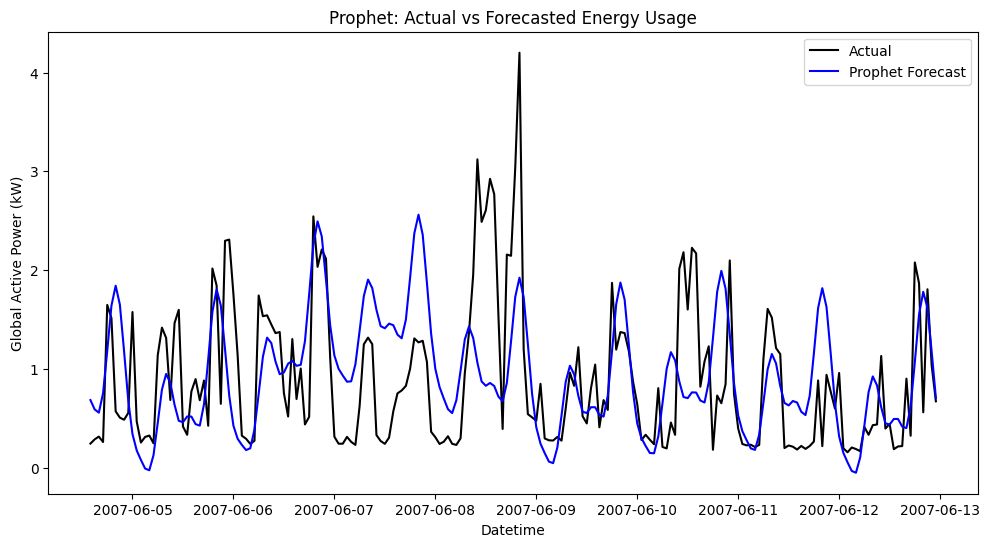

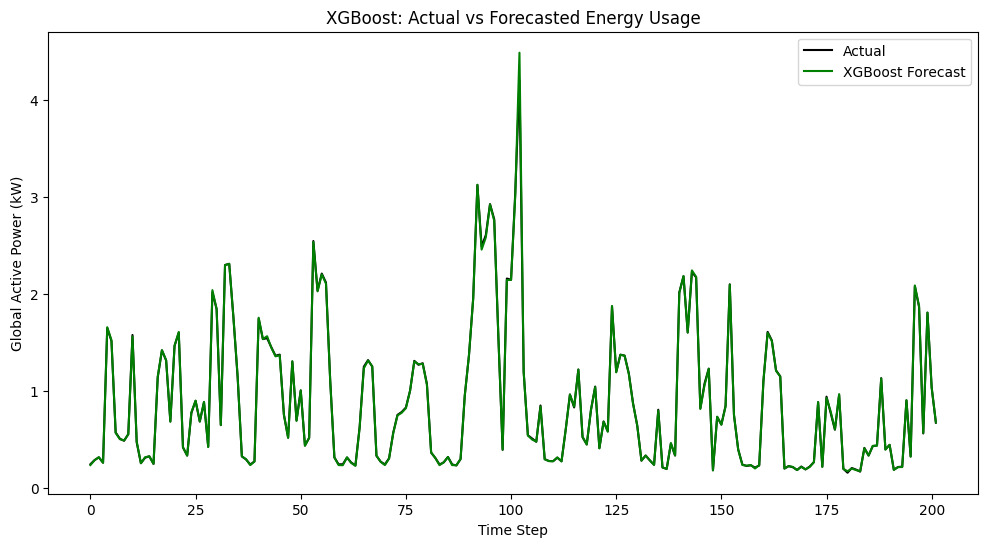

In [ ]:
import matplotlib.pyplot as plt

# --- ARIMA Plot ---
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", color="black")
plt.plot(forecast_arima, label="ARIMA Forecast", color="red")
plt.title("ARIMA: Actual vs Forecasted Energy Usage")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()

# --- Prophet Plot ---
y_pred_prophet_aligned = y_pred_prophet[:len(y_test)]

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual", color="black")
plt.plot(y_test.index, y_pred_prophet_aligned, label="Prophet Forecast", color="blue")
plt.title("Prophet: Actual vs Forecasted Energy Usage")
plt.xlabel("Datetime")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()

# --- XGBoost Plot ---
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="black")
plt.plot(y_pred_xgb, label="XGBoost Forecast", color="green")
plt.title("XGBoost: Actual vs Forecasted Energy Usage")
plt.xlabel("Time Step")
plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()


**Conclusion**

**XGBoost** clearly outperformed **ARIMA** and **Prophet**, producing forecasts that closely matched actual energy usage by capturing both trends and short-term fluctuations. **Prophet** performed better than **ARIMA**, as it modeled daily and weekly seasonality more effectively. Overall, **XGBoost** is the most reliable model for short-term household energy forecasting, while **Prophet** offers useful interpretability.

# Final Conclusion & Insights

Our analysis compared ARIMA, Prophet, and XGBoost for short-term household energy forecasting.

**XGBoost** delivered the most accurate results, closely tracking actual energy usage and effectively capturing short-term fluctuations as well as daily and weekly patterns.

**Prophet** outperformed ARIMA, modeling seasonality and trends better, but still lagged in short-term precision.

**ARIMA** provided a reasonable baseline but struggled with sudden variations in consumption.

**Key Insight:** For practical forecasting of household energy consumption, **XGBoost is the most reliable model** due to its ability to learn complex time-based patterns. Prophet remains valuable for interpretability, while ARIMA can serve as a simple benchmark.